# Project Title:
Building an NLP Model for Pediatric Respiratory Symptom Triage

## Overview
This project aims to leverage Natural Language Processing (NLP) to develop a proof-of-concept AI assistant that supports parents and caregivers in understanding and responding to common pediatric respiratory symptoms. In medical contexts where clinical intervention may not be immediately necessary, providing accessible, non-critical guidance is key to empowering better home-based decisions. By processing free-text symptom descriptions and translating them into actionable, medically-informed advice, this model seeks to serve as an intelligent triage layer—not a diagnostic tool, but a supportive aid for symptom interpretation.

## Objective
To develop an NLP-powered machine learning model that classifies free-text pediatric respiratory symptom descriptions into predefined, non-critical guidance categories such as:

- Monitor at Home
- Use Inhaler as Prescribed
- Consult General Practitioner
- Visit Emergency Room

**This project encapsulates the full NLP development lifecycle including:**

- Text preprocessing and cleaning
- Feature extraction using statistical or deep embeddings
- Model training using traditional ML and/or transformer-based classifiers
- Evaluation via accuracy, precision, recall, F1-score, and confusion matrix
- Packaging into an interface-ready deployment layer for real-world interaction


## Step 1: Define the Problem

**NLP** or **Natural Language Processing** is the ability by which AI models can *understand* natural language *inputs* and *process them to work with*. Now, this naturally has far-reaching ripples—especially in a *language-intensive* space like the medical industry. In contexts where critical precision and patient clarity are both vital, NLP can bridge the communication gap between clinical terminology and layman understanding. By enabling AI systems to interpret symptoms described in plain language and return non-critical, guidance-level advice, NLP empowers patients and caregivers to make informed next steps—without the overload of medical jargon or the risk of misinterpretation. It ensures that help feels both reliable and relatable.

In [1]:
# ======================================================
# Step 1 – Importing Libraries & Setting Up Rich Logging
# ======================================================

# Rich logging & progress visualization
from rich.console import Console
from rich.progress import Progress, SpinnerColumn, BarColumn, TextColumn
from rich.traceback import install

# Enable rich tracebacks for cleaner error messages
install()
console = Console()

# Helper to print step headers
def log_step(step_name):
    console.rule(f"[bold blue]{step_name}")

# Progress display template
def create_progress():
    return Progress(
        SpinnerColumn(),
        "[progress.description]{task.description}",
        BarColumn(),
        TextColumn("{task.completed}/{task.total}")
    )

# Standard utilities
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import sys
import traceback

# Data processing & model libraries
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, pipeline
from peft import LoraConfig, get_peft_model
import torch

# Gradio interface
import gradio as gr

##  Step 2

In [2]:
# ======================================================
# Step 2 – Data Loading & Previewing
# ======================================================

import pandas as pd

def load_data(file_paths):
    """Loads multiple tab-separated text files into a single DataFrame."""
    dfs = []
    for file in tqdm(file_paths, desc="Loading dataset files"):
        try:
            console.log(f"[cyan]Reading file:[/cyan] {file}")
            df = pd.read_csv(file, delimiter="\t", header=None, dtype=str)
            dfs.append(df)
        except Exception as e:
            console.log(f"[red]Error reading {file}[/red]: {e}")
            console.print_exception()
    combined_df = pd.concat(dfs, ignore_index=True)
    console.log(f"[green]✅ Dataset loaded with shape {combined_df.shape}[/green]")
    return combined_df

try:
    log_step("Step 2 – Data Loading & Previewing")

    files = [
        "./Dataset/PEDIATRIC PULMONOLOGY.txt",
        "./Dataset/PEDIATRIC PULMONOLOGY 2.txt"
    ]

    df_raw = load_data(files)
    console.log(f"First 5 rows of the raw dataset:")
    console.print(df_raw.head(), highlight=True)

except Exception as e:
    console.log("[red]❌ Failed to load and preview dataset[/red]")
    console.print_exception()

─────────────────────────────────────── Step 2 – Data Loading & Previewing ────────────────────────────────────────

Loading dataset files:   0%|          | 0/2 [00:00<?, ?it/s]

[20:39:41] Reading file: ./Dataset/PEDIATRIC PULMONOLOGY.txt                                       ]8;id=800389;file:///tmp/ipykernel_30958/2952273055.py\2952273055.py]8;;\:]8;id=334106;file:///tmp/ipykernel_30958/2952273055.py#12\12]8;;\

           Reading file: ./Dataset/PEDIATRIC PULMONOLOGY 2.txt                                     ]8;id=76530;file:///tmp/ipykernel_30958/2952273055.py\2952273055.py]8;;\:]8;id=118758;file:///tmp/ipykernel_30958/2952273055.py#12\12]8;;\

Loading dataset files: 100%|██████████| 2/2 [00:00<00:00, 24.76it/s]


           ✅ Dataset loaded with shape (14689, 1)                                                 ]8;id=852783;file:///tmp/ipykernel_30958/2952273055.py\2952273055.py]8;;\:]8;id=272919;file:///tmp/ipykernel_30958/2952273055.py#19\19]8;;\

           First 5 rows of the raw dataset:                                                        ]8;id=403503;file:///tmp/ipykernel_30958/2952273055.py\2952273055.py]8;;\:]8;id=272439;file:///tmp/ipykernel_30958/2952273055.py#31\31]8;;\

0
0                              PADIATRIC PULMONOLOGY
1  Pediatric pulmonology is a medical subspecialt...
2                    WHO IS A PEDIATRIC PUMONOLOGIST
3  A pediatric pulmonologist is a doctor who spec...
4            What Does a Pediatric Pulmonologist Do?

## Step 3

In [3]:
# ======================================================
# Step 3 – Exploratory Data Analysis (EDA)
# ======================================================

def perform_eda(df):
    """Cleans basic text, removes duplicates, and runs quick statistics."""
    try:
        console.log("[cyan]Merging dataset columns into a single text field...[/cyan]")
        df["text"] = df.apply(lambda row: " ".join([str(x) for x in row if pd.notna(x)]), axis=1)

        console.log("[cyan]Cleaning whitespace...[/cyan]")
        df["text"] = df["text"].apply(lambda x: re.sub(r"\s+", " ", x).strip())

        console.log("[cyan]Dropping empty and duplicate entries...[/cyan]")
        df = df.dropna(subset=["text"]).drop_duplicates(subset=["text"]).reset_index(drop=True)

        console.log("[cyan]Calculating text length statistics...[/cyan]")
        df["length"] = df["text"].apply(len)

        console.log("[green]✅ EDA complete[/green]")
        console.log(df["length"].describe())

        return df

    except Exception as e:
        console.log("[red]❌ EDA step failed[/red]")
        console.print_exception()
        return df  # Return original df so pipeline doesn't break

try:
    log_step("Step 3 – EDA")
    df_clean = perform_eda(df_raw)
    console.log(f"First 5 cleaned entries:")
    console.print(df_clean.head(), highlight=True)
except Exception as e:
    console.log("[red]❌ Could not complete EDA[/red]")
    console.print_exception()

────────────────────────────────────────────────── Step 3 – EDA ───────────────────────────────────────────────────

[20:39:42] Merging dataset columns into a single text field...                                      ]8;id=380902;file:///tmp/ipykernel_30958/2608604836.py\2608604836.py]8;;\:]8;id=88548;file:///tmp/ipykernel_30958/2608604836.py#8\8]8;;\

           Cleaning whitespace...                                                                  ]8;id=755929;file:///tmp/ipykernel_30958/2608604836.py\2608604836.py]8;;\:]8;id=787106;file:///tmp/ipykernel_30958/2608604836.py#11\11]8;;\

           Dropping empty and duplicate entries...                                                 ]8;id=914710;file:///tmp/ipykernel_30958/2608604836.py\2608604836.py]8;;\:]8;id=716378;file:///tmp/ipykernel_30958/2608604836.py#14\14]8;;\

           Calculating text length statistics...                                                   ]8;id=569606;file:///tmp/ipykernel_30958/2608604836.py\2608604836.py]8;;\:]8;id=905717;file:///tmp/ipykernel_30958/2608604836.py#17\17]8;;\

           ✅ EDA complete                                                                         ]8;id=820655;file:///tmp/ipykernel_30958/2608604836.py\2608604836.py]8;;\:]8;id=471675;file:///tmp/ipykernel_30958/2608604836.py#20\20]8;;\

           count    12777.000000                                                                   ]8;id=990431;file:///tmp/ipykernel_30958/2608604836.py\2608604836.py]8;;\:]8;id=266374;file:///tmp/ipykernel_30958/2608604836.py#21\21]8;;\
           mean       118.940988                                                                                   
           std        118.596189                                                                                   
           min          3.000000                                                                                   
           25%         36.000000                                                                                   
           50%         75.000000                                                                                   
           75%        171.000000                                                                                   
           max       1536.000000                                                                                   
           Name: length, dtype: float64                                                                            

           First 5 cleaned entries:                                                                ]8;id=571102;file:///tmp/ipykernel_30958/2608604836.py\2608604836.py]8;;\:]8;id=622972;file:///tmp/ipykernel_30958/2608604836.py#33\33]8;;\

0  \
0                              PADIATRIC PULMONOLOGY   
1  Pediatric pulmonology is a medical subspecialt...   
2                    WHO IS A PEDIATRIC PUMONOLOGIST   
3  A pediatric pulmonologist is a doctor who spec...   
4            What Does a Pediatric Pulmonologist Do?   

                                                text  length  
0                              PADIATRIC PULMONOLOGY      21  
1  Pediatric pulmonology is a medical subspecialt...     284  
2                    WHO IS A PEDIATRIC PUMONOLOGIST      31  
3  A pediatric pulmonologist is a doctor who spec...     390  
4            What Does a Pediatric Pulmonologist Do?      39

## Step 4

─────────────────────────────────────────── Step 4 – Data Visualization ───────────────────────────────────────────

           Plotting text length distribution...                                                    ]8;id=849344;file:///tmp/ipykernel_30958/1195826806.py\1195826806.py]8;;\:]8;id=323678;file:///tmp/ipykernel_30958/1195826806.py#10\10]8;;\

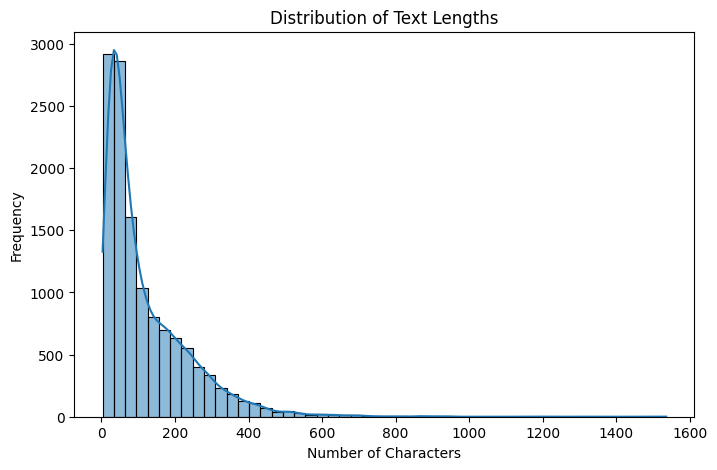

[20:39:43] Extracting top 20 most common words...                                                  ]8;id=743718;file:///tmp/ipykernel_30958/1195826806.py\1195826806.py]8;;\:]8;id=659045;file:///tmp/ipykernel_30958/1195826806.py#18\18]8;;\

           Plotting most common words...                                                           ]8;id=878216;file:///tmp/ipykernel_30958/1195826806.py\1195826806.py]8;;\:]8;id=53080;file:///tmp/ipykernel_30958/1195826806.py#23\23]8;;\

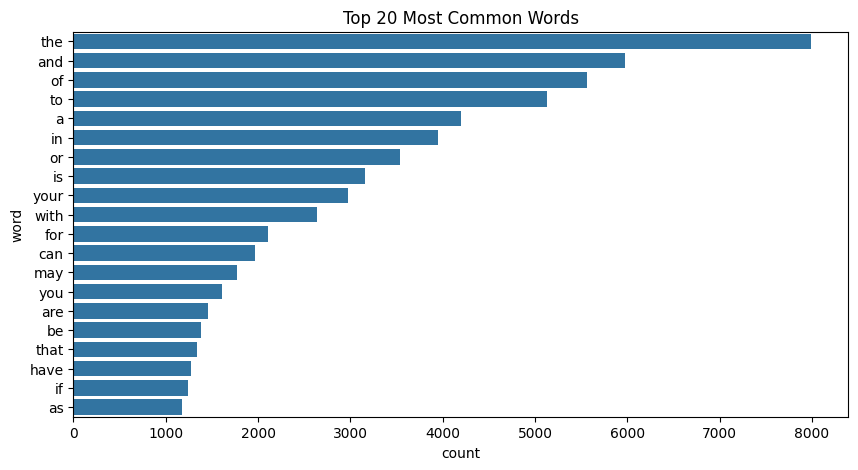

           ✅ Visualization complete                                                               ]8;id=950847;file:///tmp/ipykernel_30958/1195826806.py\1195826806.py]8;;\:]8;id=478583;file:///tmp/ipykernel_30958/1195826806.py#29\29]8;;\

In [4]:
# ======================================================
# Step 4 – Data Visualization
# ======================================================

from collections import Counter

def visualize_data(df):
    """Plots distribution of text lengths and most common words."""
    try:
        console.log("[cyan]Plotting text length distribution...[/cyan]")
        plt.figure(figsize=(8, 5))
        sns.histplot(df["length"], bins=50, kde=True)
        plt.title("Distribution of Text Lengths")
        plt.xlabel("Number of Characters")
        plt.ylabel("Frequency")
        plt.show()

        console.log("[cyan]Extracting top 20 most common words...[/cyan]")
        all_words = " ".join(df["text"]).lower().split()
        word_counts = Counter(all_words)
        common_words = pd.DataFrame(word_counts.most_common(20), columns=["word", "count"])

        console.log("[cyan]Plotting most common words...[/cyan]")
        plt.figure(figsize=(10, 5))
        sns.barplot(x="count", y="word", data=common_words)
        plt.title("Top 20 Most Common Words")
        plt.show()

        console.log("[green]✅ Visualization complete[/green]")

    except Exception as e:
        console.log("[red]❌ Visualization step failed[/red]")
        console.print_exception()

try:
    log_step("Step 4 – Data Visualization")
    visualize_data(df_clean)
except Exception as e:
    console.log("[red]❌ Could not generate visualizations[/red]")
    console.print_exception()

## Step 5

In [5]:
# ======================================================
# Step 5 – Tokenization (with labels for CausalLM)
# ======================================================

SYSTEM_PROMPT = (
    "You are a pediatric pulmonology assistant. You explain pediatric lung and airway issues "
    "in clear, safe, and simple terms. You provide mild home care tips for non-critical symptoms, "
    "and advise seeing a doctor if symptoms worsen or are severe."
)

def format_dataset(df):
    """Formats dataset into instruction-response pairs with safety guidance."""
    formatted = []
    for _, row in df.iterrows():
        output = (
            f"{row['text']}\n\n"
            "💡 **Simple Home Tips:**\n"
            "- Keep child’s environment smoke-free.\n"
            "- Maintain good hydration and rest.\n"
            "- Avoid triggers like dust, cold air, strong smells.\n"
            "- Use a humidifier in dry environments.\n\n"
            "🚨 **See a doctor if:**\n"
            "- Breathing becomes fast, noisy, or difficult.\n"
            "- Child’s lips or face turn bluish.\n"
            "- Fever persists or symptoms worsen.\n"
            "- Persistent wheezing, coughing fits, or chest pain."
        )
        formatted.append({
            "instruction": "Explain this pediatric pulmonology information with safe advice and escalation guidance.",
            "input": row["text"],
            "output": output
        })
    return formatted

def tokenize_dataset(input_file="pediatric_chatbot.json"):
    """Loads JSON dataset and tokenizes for model training."""
    try:
        console.log("[cyan]Formatting dataset...[/cyan]")
        formatted_dataset = format_dataset(df_clean)

        console.log(f"[cyan]Saving formatted dataset to {input_file}...[/cyan]")
        with open(input_file, "w") as f:
            json.dump(formatted_dataset, f, indent=2)

        console.log("[cyan]Loading tokenizer...[/cyan]")
        model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        console.log("[cyan]Loading dataset into Hugging Face format...[/cyan]")
        dataset = load_dataset("json", data_files=input_file)

        console.log("[cyan]Tokenizing dataset with labels...[/cyan]")
        def tokenize_fn(examples):
            texts = [
                f"{SYSTEM_PROMPT}\n\nInstruction: {inst}\nInput: {inp}\nOutput: {out}"
                for inst, inp, out in zip(examples["instruction"], examples["input"], examples["output"])
            ]
            tokenized = tokenizer(texts, truncation=True, max_length=2048, padding="max_length")
            tokenized["labels"] = tokenized["input_ids"].copy()  # ✅ for loss computation
            return tokenized

        tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=dataset["train"].column_names)
        tokenized_dataset = tokenized_dataset["train"].train_test_split(test_size=0.1)

        console.log("[green]✅ Tokenization complete[/green]")
        return tokenized_dataset, tokenizer, model_name

    except Exception as e:
        console.log("[red]❌ Tokenization step failed[/red]")
        console.print_exception()
        return None, None, None

try:
    log_step("Step 5 – Tokenization")
    tokenized_dataset, tokenizer, model_name = tokenize_dataset()
except Exception as e:
    console.log("[red]❌ Could not complete tokenization[/red]")
    console.print_exception()

────────────────────────────────────────────── Step 5 – Tokenization ──────────────────────────────────────────────

           Formatting dataset...                                                                   ]8;id=653083;file:///tmp/ipykernel_30958/1033110579.py\1033110579.py]8;;\:]8;id=916362;file:///tmp/ipykernel_30958/1033110579.py#38\38]8;;\

[20:39:44] Saving formatted dataset to pediatric_chatbot.json...                                   ]8;id=272008;file:///tmp/ipykernel_30958/1033110579.py\1033110579.py]8;;\:]8;id=949903;file:///tmp/ipykernel_30958/1033110579.py#41\41]8;;\

[20:39:45] Loading tokenizer...                                                                    ]8;id=20452;file:///tmp/ipykernel_30958/1033110579.py\1033110579.py]8;;\:]8;id=926519;file:///tmp/ipykernel_30958/1033110579.py#45\45]8;;\

[20:39:50] Loading dataset into Hugging Face format...                                             ]8;id=18784;file:///tmp/ipykernel_30958/1033110579.py\1033110579.py]8;;\:]8;id=614890;file:///tmp/ipykernel_30958/1033110579.py#51\51]8;;\

Generating train split: 0 examples [00:00, ? examples/s]

[20:39:52] Tokenizing dataset with labels...                                                       ]8;id=406203;file:///tmp/ipykernel_30958/1033110579.py\1033110579.py]8;;\:]8;id=544029;file:///tmp/ipykernel_30958/1033110579.py#54\54]8;;\

Map:   0%|          | 0/12777 [00:00<?, ? examples/s]

[20:40:44] ✅ Tokenization complete                                                                ]8;id=399317;file:///tmp/ipykernel_30958/1033110579.py\1033110579.py]8;;\:]8;id=173777;file:///tmp/ipykernel_30958/1033110579.py#67\67]8;;\

## Step 6

In [ ]:
# ======================================================
# Step 6 – Model Fine-Tuning (LoRA on TinyLlama-1.1B)
# ======================================================

def finetune_model(tokenized_dataset, tokenizer, model_name):
    """Fine-tunes TinyLlama with LoRA on the prepared dataset."""
    try:
        console.log("[cyan]Loading base model (full precision, CPU mode)...[/cyan]")
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto"  # CPU in your case
        )

        console.log("[cyan]Applying LoRA configuration...[/cyan]")
        lora_config = LoraConfig(
            task_type="CAUSAL_LM",
            r=8,
            lora_alpha=32,
            lora_dropout=0.05,
            bias="none"
        )
        model = get_peft_model(model, lora_config)

        console.log("[cyan]Setting up training arguments...[/cyan]")
        training_args = TrainingArguments(
            output_dir="./tinyllama-medical",
            per_device_train_batch_size=2,
            gradient_accumulation_steps=4,
            learning_rate=2e-4,
            num_train_epochs=3,
            save_strategy="epoch",
            logging_dir="./logs",
            logging_steps=1,                 # ✅ show logs every step
            report_to="none",                 # ✅ no WandB/Hub logging
            fp16=False,                       # ✅ CPU
            dataloader_pin_memory=False       # ✅ remove GPU pin warning
        )

        console.log("[cyan]Initializing Trainer...[/cyan]")
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_dataset["train"],
            eval_dataset=tokenized_dataset["test"],
            processing_class=tokenizer,       # ✅ future-proof
        )

        console.log("[cyan]Starting training...[/cyan]")
        trainer.train()

        console.log("[green]✅ Fine-tuning complete. Saving model...[/green]")
        model.save_pretrained("./tinyllama-medical")
        tokenizer.save_pretrained("./tinyllama-medical")

        return model

    except Exception as e:
        console.log("[red]❌ Fine-tuning step failed[/red]")
        console.print_exception()
        return None

try:
    log_step("Step 6 – Model Fine-Tuning")
    model = finetune_model(tokenized_dataset, tokenizer, model_name)
except Exception as e:
    console.log("[red]❌ Could not complete model fine-tuning[/red]")
    console.print_exception()

─────────────────────────────────────────── Step 6 – Model Fine-Tuning ────────────────────────────────────────────

[20:41:32] Loading base model (full precision, CPU mode)...                                         ]8;id=864618;file:///tmp/ipykernel_30958/1592299403.py\1592299403.py]8;;\:]8;id=617342;file:///tmp/ipykernel_30958/1592299403.py#8\8]8;;\

[20:41:34] Applying LoRA configuration...                                                          ]8;id=455115;file:///tmp/ipykernel_30958/1592299403.py\1592299403.py]8;;\:]8;id=239080;file:///tmp/ipykernel_30958/1592299403.py#14\14]8;;\

           Setting up training arguments...                                                        ]8;id=369845;file:///tmp/ipykernel_30958/1592299403.py\1592299403.py]8;;\:]8;id=348097;file:///tmp/ipykernel_30958/1592299403.py#24\24]8;;\

           Initializing Trainer...                                                                 ]8;id=351513;file:///tmp/ipykernel_30958/1592299403.py\1592299403.py]8;;\:]8;id=349344;file:///tmp/ipykernel_30958/1592299403.py#39\39]8;;\

           Starting training...                                                                    ]8;id=256787;file:///tmp/ipykernel_30958/1592299403.py\1592299403.py]8;;\:]8;id=234053;file:///tmp/ipykernel_30958/1592299403.py#48\48]8;;\

Step,Training Loss


## Step 7

In [7]:
# ======================================================
# Step 7 – Evaluation
# ======================================================

def evaluate_model(model, tokenizer):
    """Runs a quick test prompt on the fine-tuned model."""
    try:
        console.log("[cyan]Loading pipeline for evaluation...[/cyan]")
        pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            device_map="auto"
        )

        test_prompt = "My child has a mild cough at night, what can I do?"
        console.log(f"[cyan]Testing model with sample input:[/cyan] {test_prompt}")

        result = pipe(
            f"{SYSTEM_PROMPT}\n\nInstruction: Provide advice.\nInput: {test_prompt}\nOutput:",
            max_length=512,
            do_sample=True,
            temperature=0.7
        )

        console.log("[green]✅ Evaluation complete. Model output:[/green]")
        console.print(result[0]["generated_text"])

    except Exception as e:
        console.log("[red]❌ Evaluation step failed[/red]")
        console.print_exception()

try:
    log_step("Step 7 – Evaluation")
    evaluate_model(model, tokenizer)
except Exception as e:
    console.log("[red]❌ Could not complete evaluation[/red]")
    console.print_exception()

─────────────────────────────────────────────── Step 7 – Evaluation ───────────────────────────────────────────────

           Loading pipeline for evaluation...                                                       ]8;id=147757;file:///tmp/ipykernel_30958/1973641506.py\1973641506.py]8;;\:]8;id=273631;file:///tmp/ipykernel_30958/1973641506.py#8\8]8;;\

           ❌ Evaluation step failed                                                               ]8;id=379442;file:///tmp/ipykernel_30958/1973641506.py\1973641506.py]8;;\:]8;id=388641;file:///tmp/ipykernel_30958/1973641506.py#30\30]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in evaluate_model:9                                                                              │
│                                                                                                  │
│    6 │   """Runs a quick test prompt on the fine-tuned model."""                                 │
│    7 │   try:                                                                                    │
│    8 │   │   console.log("[cyan]Loading pipeline for evaluation...[/cyan]")                      │
│ ❱  9 │   │   pipe = pipeline(                                                                    │
│   10 │   │   │   "text-generation",                                                              │
│   11 │   │   │   model=model,                                                                    │
│   12 │   │   │   tokenizer=tokenizer,                                                            │
│                                                                                                  │
│ /home/silver/anaconda3/lib/python3.13/site-packages/transformers/pipelines/__init__.py:847 in    │
│ pipeline                                                                                         │
│                                                                                                  │
│    844 │   │   )                                                                                 │
│    845 │                                                                                         │
│    846 │   if model is None and tokenizer is not None:                                           │
│ ❱  847 │   │   raise RuntimeError(                                                               │
│    848 │   │   │   "Impossible to instantiate a pipeline with tokenizer specified but not the m  │
│    849 │   │   │   " may not be compatible with the default model. Please provide a PreTrainedM  │
│    850 │   │   │   " path/identifier to a pretrained model when providing tokenizer."            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Impossible to instantiate a pipeline with tokenizer specified but not the model as the provided 
tokenizer may not be compatible with the default model. Please provide a PreTrainedModel class or a path/identifier
to a pretrained model when providing tokenizer.

## Step 8

In [8]:
# ======================================================
# Step 8 – Gradio Interface
# ======================================================

def launch_gradio_chatbot(model, tokenizer):
    """Launches a Gradio chatbot interface for the fine-tuned model."""
    try:
        console.log("[cyan]Setting up text-generation pipeline for Gradio...[/cyan]")
        pipe = pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            device_map="auto"
        )

        def chatbot_response(user_input):
            prompt = f"{SYSTEM_PROMPT}\n\nInstruction: Provide advice.\nInput: {user_input}\nOutput:"
            result = pipe(prompt, max_length=512, do_sample=True, temperature=0.7)
            return result[0]["generated_text"]

        console.log("[cyan]Launching Gradio interface...[/cyan]")
        iface = gr.Interface(
            fn=chatbot_response,
            inputs=gr.Textbox(
                lines=3,
                placeholder="Ask about a pediatric respiratory issue..."
            ),
            outputs="text",
            title="Pediatric Pulmonology Assistant",
            description="Provides non-critical advice with escalation guidance for pediatric respiratory issues."
        )

        iface.launch(share=True)

    except Exception as e:
        console.log("[red]❌ Gradio interface launch failed[/red]")
        console.print_exception()

try:
    log_step("Step 8 – Gradio Interface")
    launch_gradio_chatbot(model, tokenizer)
except Exception as e:
    console.log("[red]❌ Could not launch Gradio interface[/red]")
    console.print_exception()


──────────────────────────────────────────── Step 8 – Gradio Interface ────────────────────────────────────────────

[20:40:49] Setting up text-generation pipeline for Gradio...                                         ]8;id=867965;file:///tmp/ipykernel_30958/173306640.py\173306640.py]8;;\:]8;id=917038;file:///tmp/ipykernel_30958/173306640.py#8\8]8;;\

           ❌ Gradio interface launch failed                                                        ]8;id=443235;file:///tmp/ipykernel_30958/173306640.py\173306640.py]8;;\:]8;id=864206;file:///tmp/ipykernel_30958/173306640.py#36\36]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in launch_gradio_chatbot:9                                                                       │
│                                                                                                  │
│    6 │   """Launches a Gradio chatbot interface for the fine-tuned model."""                     │
│    7 │   try:                                                                                    │
│    8 │   │   console.log("[cyan]Setting up text-generation pipeline for Gradio...[/cyan]")       │
│ ❱  9 │   │   pipe = pipeline(                                                                    │
│   10 │   │   │   "text-generation",                                                              │
│   11 │   │   │   model=model,                                                                    │
│   12 │   │   │   tokenizer=tokenizer,                                                            │
│                                                                                                  │
│ /home/silver/anaconda3/lib/python3.13/site-packages/transformers/pipelines/__init__.py:847 in    │
│ pipeline                                                                                         │
│                                                                                                  │
│    844 │   │   )                                                                                 │
│    845 │                                                                                         │
│    846 │   if model is None and tokenizer is not None:                                           │
│ ❱  847 │   │   raise RuntimeError(                                                               │
│    848 │   │   │   "Impossible to instantiate a pipeline with tokenizer specified but not the m  │
│    849 │   │   │   " may not be compatible with the default model. Please provide a PreTrainedM  │
│    850 │   │   │   " path/identifier to a pretrained model when providing tokenizer."            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: Impossible to instantiate a pipeline with tokenizer specified but not the model as the provided 
tokenizer may not be compatible with the default model. Please provide a PreTrainedModel class or a path/identifier
to a pretrained model when providing tokenizer.